# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

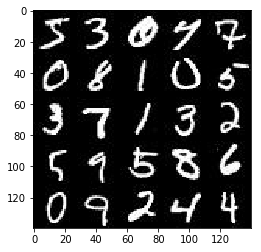

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

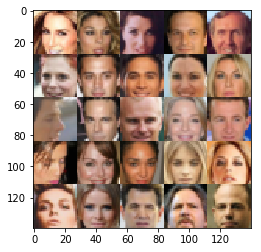

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


D:\Anaconda3\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    # The real inputs are a tensor of rank 4:
    real_inputs = tf.placeholder(tf.float32, 
                                 shape=(None, image_width, image_height, image_channels), 
                                 name='real_input')
    #real_inputs.mark_used()
    
    # The z data is a tensor of rank 2:
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_data')
    #z_data.mark_used()
    
    # alpha, the learning rate, is a real-valued scalar:
    alpha = tf.placeholder(tf.float32, name='learning_rate')
    
    return (real_inputs, z_data, alpha)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "D:\\Anaconda3\\envs\\TensorFlow\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "D:\\Anaconda3\\envs\\TensorFlow\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "D:\\Anaconda3\\envs\\TensorFlow\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "D:\\Anaconda3\\envs\\TensorFlow\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "D:\\Anaconda3\\envs\\TensorFlow\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "D:\\Anaconda3\\envs\\TensorFlow\\lib\\site-packages\\

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # The following network is based on the network used in the paper
    # "Unsupervised Representation Learning With Deep Convolutional 
    #  Generative Adversarial Networks" by Radford, Metz, and Chintala
    # It is available on the arxiv server:  https://arxiv.org/pdf/1511.06434.pdf
    #
    # This Deep Convolution GAN (DCGAN) network consists of 5 layers:
    #   1.  A 5x5 2D convolution layer (with sride of 2) followed by leaky Relu
    #   2.  Another 5x5 2D convolution with stride of 2, followed by batch-normalization and lRelu
    #   3.  A 3rd 5x5 2D convolution, this time with a stride of 1, followed by batch-norm and lRelu
    #   4.  A 4th 5x5 2D convolution, stride of 1, followed by batch-norm and leaky-Relu
    #   5.  A flattening layer followed by a sigmoid activation function to form the final outputs
    
    # All leaky Relus use the same "leakage" parameter -- essentially the slope of
    # the negative half of the Relu
    relu_leakage = 0.20 # (as recommended by the DCGAN paper)
    
    keep_prob = 0.6 # For dropout after each lRelu layer
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # using 4 layer network as in DCGAN Paper
        
        # Convolution Layer 1
        # Reduce image size from 28x28x1 (for MNIST) or 28x28x3 (for celebs - with 3 color channels)
        # To 14x14x64
        conv_layer_1 = tf.layers.conv2d(inputs      = images,
                                        filters     = 64, 
                                        kernel_size =  5, 
                                        strides     =  2, 
                                        padding     = 'SAME',
                                        kernel_initializer = tf.contrib.layers.xavier_initializer())
        
        leaky_relu_1 = tf.maximum(relu_leakage * conv_layer_1, conv_layer_1)
        leaky_relu_1 = tf.nn.dropout(leaky_relu_1, keep_prob)
        
        # Convolution Layer 2
        # Reduce image size again, to 7x7x128
        conv_layer_2 = tf.layers.conv2d(inputs    = leaky_relu_1, 
                                        filters   = 128, 
                                        kernel_size = 5, 
                                        strides     = 2, 
                                        padding     = 'SAME',
                                        kernel_initializer = tf.contrib.layers.xavier_initializer())
        
        batch_norm_2 = tf.layers.batch_normalization(conv_layer_2, training=True)
        
        leaky_relu_2 = tf.maximum(relu_leakage * batch_norm_2, batch_norm_2)
        leaky_relu_2 = tf.nn.dropout(leaky_relu_2, keep_prob)
        
        # Convolution Layer 3
        # And, again, to 4x4x256
        conv_layer_3 = tf.layers.conv2d(inputs      = leaky_relu_2, 
                                        filters     = 256, 
                                        kernel_size = 5, 
                                        strides     = 1,
                                        padding     = 'SAME',
                                        kernel_initializer = tf.contrib.layers.xavier_initializer())
        
        batch_norm_3 = tf.layers.batch_normalization(conv_layer_3, training=True)
        
        leaky_relu_3 = tf.maximum(relu_leakage * batch_norm_3, batch_norm_3)        
        leaky_relu_3 = tf.nn.dropout(leaky_relu_3, keep_prob)
        
        # Convolution Layer 4
        # One last time, to 
        conv_layer_4 = tf.layers.conv2d(inputs      = leaky_relu_3, 
                                        filters     = 512, 
                                        kernel_size = 5, 
                                        strides     = 1, 
                                        padding     = 'SAME',                                       
                                        kernel_initializer = tf.contrib.layers.xavier_initializer())
        
        batch_norm_4 = tf.layers.batch_normalization(conv_layer_4, training=True)
        
        leaky_relu_4 = tf.maximum(relu_leakage * batch_norm_4, batch_norm_4)
        leaky_relu_4 = tf.nn.dropout(leaky_relu_4, keep_prob)
       
        # Layer 5:  Flatten, Logits, and Output
        flat_layer = tf.reshape(leaky_relu_4, (-1, 7*7*512))
        logits     = tf.layers.dense(flat_layer, 1)
        outputs    = tf.sigmoid(logits)
        
        return (outputs, logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # The GAN generator generally implements the reverse of the convolution layers:
    # De-convolving the outputs to go from 512-to-256-to-128-to-64 pixels
    # The final output layer uses a tanh activation function, rather than the sigmoid
    # that was used in the discriminator
    
    # As before, use the same relu-leakage slope for all leaky Relus
    relu_leakage = 0.20 # As recommended in the DCGAN paper
    
    keep_prob = 0.6 # for dropout
    
    #print ("z-shape=", z.shape)
    
    with tf.variable_scope('generator', 
                           reuse=False if is_train==True else True):
        
        # The generator starts with a fully-connected layer
        fc_layer_1 = tf.layers.dense(z, 7*7*512)
        fc_layer_1 = tf.reshape(fc_layer_1, (-1, 7, 7, 512))
        fc_layer_1 = tf.maximum(relu_leakage*fc_layer_1, fc_layer_1)
        
        ####################################
        # Perform 3 layers of de-convolution
        ####################################
        
        # Layer 2
        de_conv_layer_2 = tf.layers.conv2d_transpose(inputs      = fc_layer_1, 
                                                     filters     = 256, 
                                                     kernel_size =   5, 
                                                     strides     =   1, 
                                                     padding     = 'SAME',
                                                     kernel_initializer = tf.contrib.layers.xavier_initializer())
        batch_norm_2    = tf.layers.batch_normalization(de_conv_layer_2, training=is_train)
        leaky_relu_2    = tf.maximum(relu_leakage * batch_norm_2, batch_norm_2)        
        leaky_relu_2    = tf.nn.dropout(leaky_relu_2, keep_prob)
        
        # Layer 3
        de_conv_layer_3 = tf.layers.conv2d_transpose(inputs      = leaky_relu_2, 
                                                     filters     = 128, 
                                                     kernel_size =   5, 
                                                     strides     =   2, 
                                                     padding     = 'SAME',
                                                     kernel_initializer = tf.contrib.layers.xavier_initializer())
        batch_norm_3 = tf.layers.batch_normalization(de_conv_layer_3, training=is_train)
        leaky_relu_3 = tf.maximum(relu_leakage * batch_norm_3, batch_norm_3)        
        leaky_relu_3 = tf.nn.dropout(leaky_relu_3, keep_prob)
        
        # Layer 4
        de_conv_layer_4 = tf.layers.conv2d_transpose(inputs      = leaky_relu_3, 
                                                     filters     = 64, 
                                                     kernel_size =  5, 
                                                     strides     =  2, 
                                                     padding     = 'SAME',
                                                     kernel_initializer = tf.contrib.layers.xavier_initializer())
        batch_norm_4    = tf.layers.batch_normalization(de_conv_layer_4, training=is_train)
        leaky_relu_4    = tf.maximum(relu_leakage * batch_norm_4, batch_norm_4)        
        leaky_relu_4    = tf.nn.dropout(leaky_relu_4, keep_prob)
        
        # Logits and output layer
        logits = tf.layers.conv2d_transpose(inputs      = leaky_relu_4, 
                                            filters     = out_channel_dim, 
                                            kernel_size = 5, 
                                            strides     = 2, 
                                            padding     = 'SAME')
        
        # Reshape final outputs to 28x28 to match original input size
        logits_reshaped = tf.image.resize_images(logits, size=(28, 28))
        
        out = tf.tanh(logits_reshaped)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # Calculate a loss metric for the generator and discriminator set of models    
    generator_model = generator(input_z, out_channel_dim)
    
    # To get both real and generated discriminator outputs, apply the discriminator
    # to both the real input data and the data generated by the generator
    disc_real, disc_logits_real = discriminator(input_real)
    disc_gen,  disc_logits_gen  = discriminator(generator_model, reuse=True)
    
    # Use cross-entropy metric to calculate loss of the real and generated images
    smoothed_real_labels = 0.95
    disc_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_logits_real, 
                                                              labels = tf.ones_like(disc_real) * smoothed_real_labels))
    disc_loss_gen  = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_logits_gen, 
                                                              labels = tf.zeros_like(disc_gen)))
    
    # The total discriminator loss consists of both the real and generated loss metrics
    discriminator_loss = disc_loss_real + disc_loss_gen

    # The generator loss metric is just the cross-entropy metric for the generator
    generator_loss = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_logits_gen,
                                                                labels = tf.ones_like(disc_gen)))
    
    return (discriminator_loss, generator_loss)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Use the Adam optimizer to optimize the model learning
    training_vars      = tf.trainable_variables()
    discriminator_vars = [var for var in training_vars if var.name.startswith('discriminator')]
    generator_vars     = [var for var in training_vars if var.name.startswith('generator')]

    # Optimize
    discriminator_optimizer = tf.train.AdamOptimizer(learning_rate, 
                                                     beta1=beta1).minimize(d_loss, 
                                                                           var_list=discriminator_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS,
                                                   scope = 'generator')):
        generator_optimizer = tf.train.AdamOptimizer(learning_rate,
                                                     beta1=beta1).minimize(g_loss, 
                                                                           var_list=generator_vars)

    return (discriminator_optimizer, generator_optimizer)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    ##############################################################
    # Initialize both the discriminator and generator models
    ##############################################################
    tf.reset_default_graph()
    
    # Use model_inputs to initialize the inputs
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # Calculate the discriminator and generator loss metrics
    discriminator_loss, generator_loss = model_loss(input_real, input_z, data_shape[3])
    
    # Initialize the Adam optimzer for both the discriminator and generator 
    discriminator, generator = model_opt(discriminator_loss, 
                                         generator_loss, 
                                         learning_rate, 
                                         beta1)
    
    # Keep track of the number of iterations
    iter = 0
    
    #############################################################
    # Train the model
    #############################################################
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # Normalize batch images to be from -1 to +1
                batch_images = batch_images * 2
                iter += 1
            
                # Sample z values from -1 to +1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run the discriminator flow graph
                sess.run(discriminator, 
                             feed_dict={input_real : batch_images, 
                                        input_z    : batch_z})
                
                # And, the generator
                sess.run(generator, feed_dict={input_z: batch_z})
                
                if iter % 100 == 0:
                    # At the end of every 100 iterations, print out the loss metrics
                    # for both the discriminator and generator
                    d_loss = discriminator_loss.eval({input_z    : batch_z, 
                                                      input_real : batch_images})
                    
                    g_loss = generator_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} \n".format(epoch_i+1, epochs),
                          "Iteration {} \n".format(iter),
                          "Discriminator Loss = {:.4f} \n".format(d_loss),
                          "Generator Loss     = {:.4f} \n".format(g_loss))
                    
                    # Show 25 of the images to see how things are doing
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/4 
 Iteration 100 
 Discriminator Loss = 1.3053 
 Generator Loss     = 2.8712 



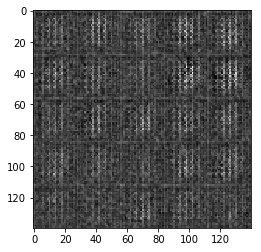

Epoch 1/4 
 Iteration 200 
 Discriminator Loss = 1.3454 
 Generator Loss     = 0.9388 



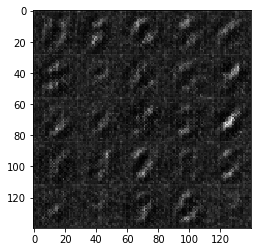

Epoch 1/4 
 Iteration 300 
 Discriminator Loss = 1.2807 
 Generator Loss     = 1.5460 



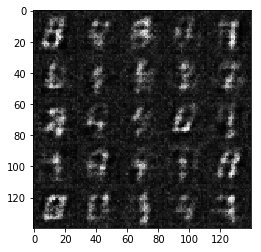

Epoch 1/4 
 Iteration 400 
 Discriminator Loss = 1.5898 
 Generator Loss     = 0.6948 



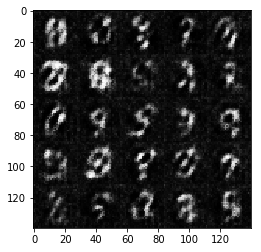

Epoch 1/4 
 Iteration 500 
 Discriminator Loss = 1.4102 
 Generator Loss     = 1.3249 



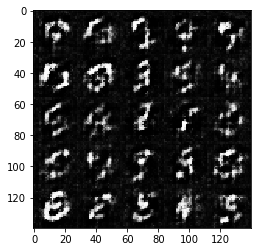

Epoch 1/4 
 Iteration 600 
 Discriminator Loss = 1.6734 
 Generator Loss     = 2.3223 



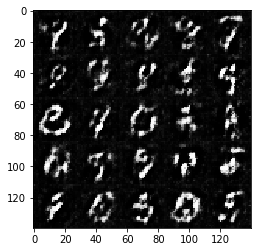

Epoch 1/4 
 Iteration 700 
 Discriminator Loss = 1.1271 
 Generator Loss     = 1.1103 



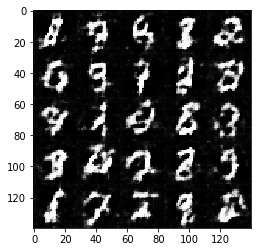

Epoch 1/4 
 Iteration 800 
 Discriminator Loss = 1.3134 
 Generator Loss     = 1.6974 



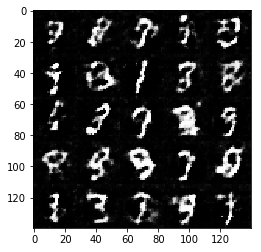

Epoch 1/4 
 Iteration 900 
 Discriminator Loss = 1.1832 
 Generator Loss     = 1.9799 



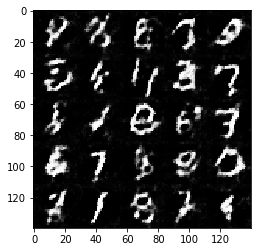

Epoch 2/4 
 Iteration 1000 
 Discriminator Loss = 1.2261 
 Generator Loss     = 1.0710 



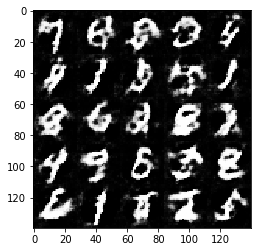

Epoch 2/4 
 Iteration 1100 
 Discriminator Loss = 1.3174 
 Generator Loss     = 1.2150 



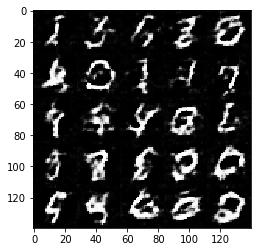

Epoch 2/4 
 Iteration 1200 
 Discriminator Loss = 0.9710 
 Generator Loss     = 1.2727 



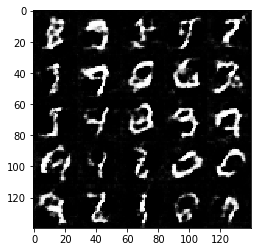

Epoch 2/4 
 Iteration 1300 
 Discriminator Loss = 1.0506 
 Generator Loss     = 2.0052 



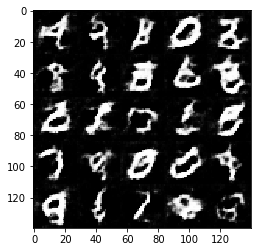

Epoch 2/4 
 Iteration 1400 
 Discriminator Loss = 1.4780 
 Generator Loss     = 0.7352 



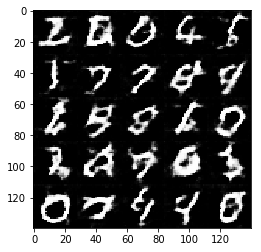

Epoch 2/4 
 Iteration 1500 
 Discriminator Loss = 1.1611 
 Generator Loss     = 1.0591 



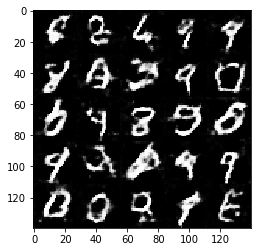

Epoch 2/4 
 Iteration 1600 
 Discriminator Loss = 0.9350 
 Generator Loss     = 1.1965 



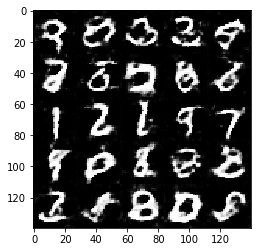

Epoch 2/4 
 Iteration 1700 
 Discriminator Loss = 1.5397 
 Generator Loss     = 2.3810 



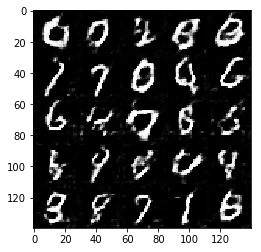

Epoch 2/4 
 Iteration 1800 
 Discriminator Loss = 1.1365 
 Generator Loss     = 0.9478 



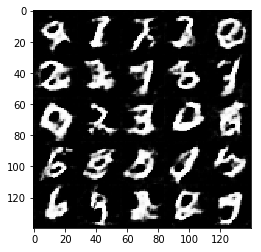

Epoch 3/4 
 Iteration 1900 
 Discriminator Loss = 1.0128 
 Generator Loss     = 0.9418 



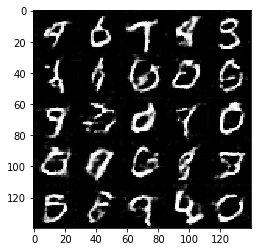

Epoch 3/4 
 Iteration 2000 
 Discriminator Loss = 0.9254 
 Generator Loss     = 1.3255 



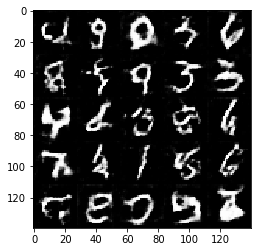

Epoch 3/4 
 Iteration 2100 
 Discriminator Loss = 1.1752 
 Generator Loss     = 2.8077 



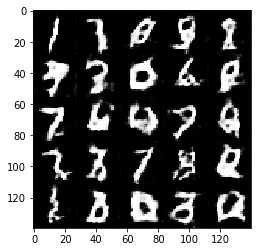

IndexError: list index out of range

In [18]:
batch_size    =  64
z_dim         = 100      # Based on DCGAN paper
learning_rate =   0.0002 # The DCGAN paper recommended 0.0002...
beta1         =   0.50   # The DCGAN paper recommended 0.5 for stability


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 
 Iteration 100 
 Discriminator Loss = 0.7627 
 Generator Loss     = 2.2705 



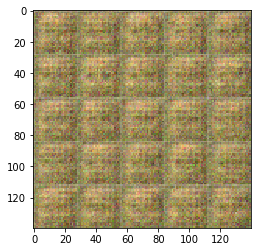

Epoch 1/1 
 Iteration 200 
 Discriminator Loss = 0.7059 
 Generator Loss     = 3.0282 



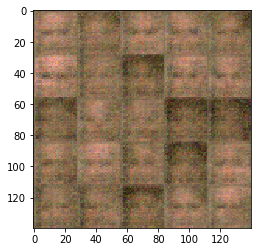

Epoch 1/1 
 Iteration 300 
 Discriminator Loss = 0.6623 
 Generator Loss     = 1.8214 



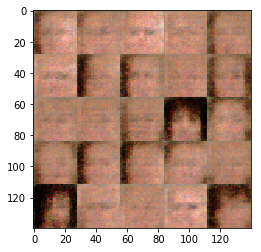

Epoch 1/1 
 Iteration 400 
 Discriminator Loss = 0.8676 
 Generator Loss     = 2.8429 



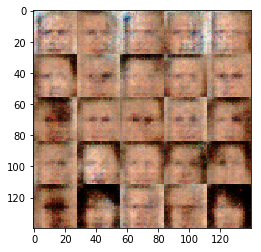

Epoch 1/1 
 Iteration 500 
 Discriminator Loss = 0.9969 
 Generator Loss     = 1.3007 



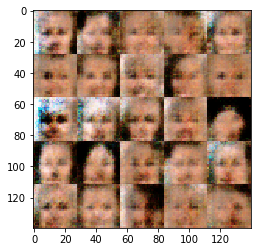

Epoch 1/1 
 Iteration 600 
 Discriminator Loss = 0.7750 
 Generator Loss     = 2.9976 



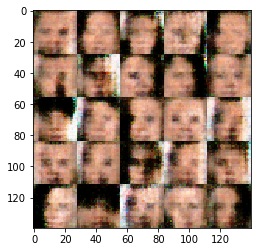

Epoch 1/1 
 Iteration 700 
 Discriminator Loss = 0.8698 
 Generator Loss     = 1.7058 



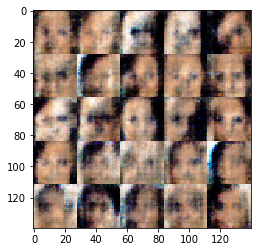

Epoch 1/1 
 Iteration 800 
 Discriminator Loss = 1.0974 
 Generator Loss     = 1.1199 



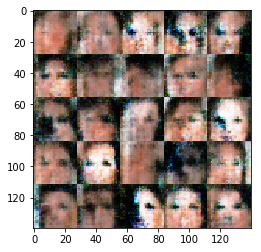

Epoch 1/1 
 Iteration 900 
 Discriminator Loss = 1.5944 
 Generator Loss     = 1.1126 



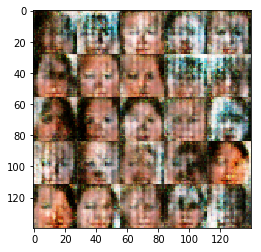

Epoch 1/1 
 Iteration 1000 
 Discriminator Loss = 0.9321 
 Generator Loss     = 1.3593 



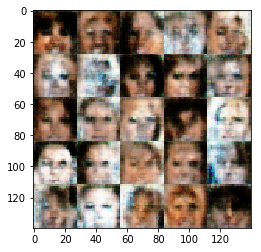

Epoch 1/1 
 Iteration 1100 
 Discriminator Loss = 1.5818 
 Generator Loss     = 1.3903 



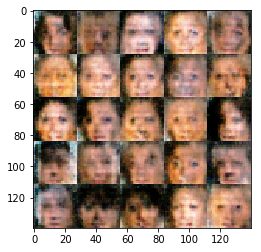

Epoch 1/1 
 Iteration 1200 
 Discriminator Loss = 1.1058 
 Generator Loss     = 1.3612 



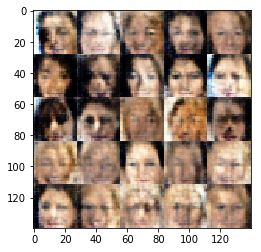

Epoch 1/1 
 Iteration 1300 
 Discriminator Loss = 1.6340 
 Generator Loss     = 1.4330 



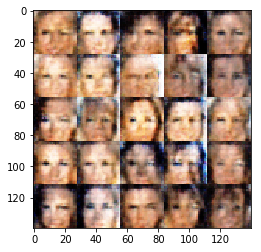

Epoch 1/1 
 Iteration 1400 
 Discriminator Loss = 1.2431 
 Generator Loss     = 0.7878 



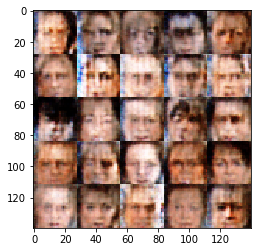

Epoch 1/1 
 Iteration 1500 
 Discriminator Loss = 1.3270 
 Generator Loss     = 1.2811 



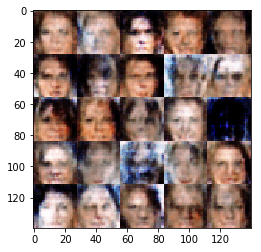

Epoch 1/1 
 Iteration 1600 
 Discriminator Loss = 1.5200 
 Generator Loss     = 1.5230 



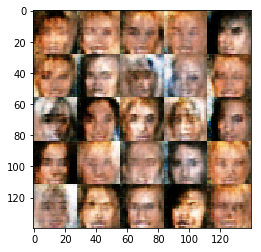

Epoch 1/1 
 Iteration 1700 
 Discriminator Loss = 0.9783 
 Generator Loss     = 1.0832 



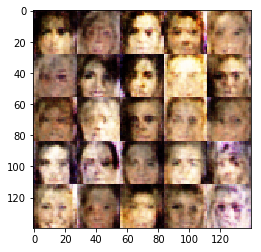

Epoch 1/1 
 Iteration 1800 
 Discriminator Loss = 0.9169 
 Generator Loss     = 1.1608 



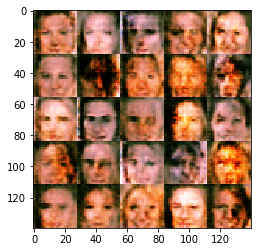

Epoch 1/1 
 Iteration 1900 
 Discriminator Loss = 0.9222 
 Generator Loss     = 1.0730 



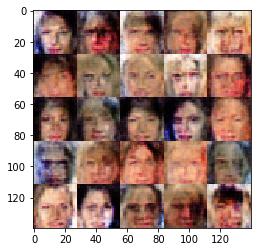

Epoch 1/1 
 Iteration 2000 
 Discriminator Loss = 1.2373 
 Generator Loss     = 1.6571 



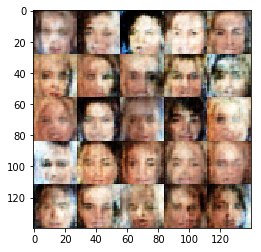

Epoch 1/1 
 Iteration 2100 
 Discriminator Loss = 1.2736 
 Generator Loss     = 0.9868 



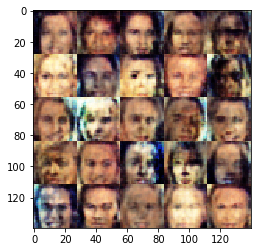

Epoch 1/1 
 Iteration 2200 
 Discriminator Loss = 1.1304 
 Generator Loss     = 0.7314 



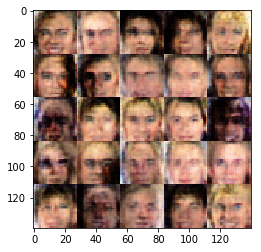

Epoch 1/1 
 Iteration 2300 
 Discriminator Loss = 1.1655 
 Generator Loss     = 0.9691 



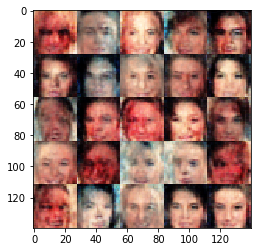

Epoch 1/1 
 Iteration 2400 
 Discriminator Loss = 1.0654 
 Generator Loss     = 1.1197 



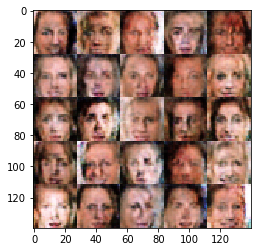

Epoch 1/1 
 Iteration 2500 
 Discriminator Loss = 2.0122 
 Generator Loss     = 1.9960 



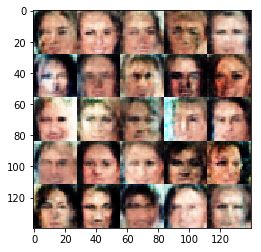

Epoch 1/1 
 Iteration 2600 
 Discriminator Loss = 2.1477 
 Generator Loss     = 0.4844 



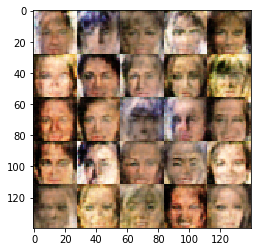

Epoch 1/1 
 Iteration 2700 
 Discriminator Loss = 1.3895 
 Generator Loss     = 0.8274 



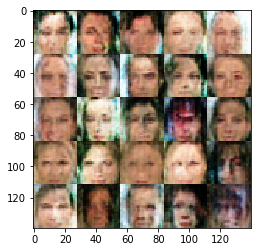

Epoch 1/1 
 Iteration 2800 
 Discriminator Loss = 1.3667 
 Generator Loss     = 0.5980 



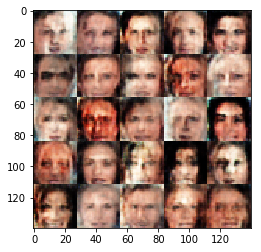

Epoch 1/1 
 Iteration 2900 
 Discriminator Loss = 1.1080 
 Generator Loss     = 1.0145 



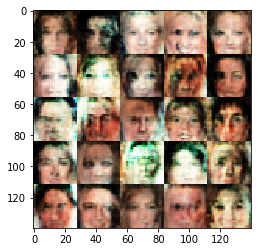

Epoch 1/1 
 Iteration 3000 
 Discriminator Loss = 1.1424 
 Generator Loss     = 0.7071 



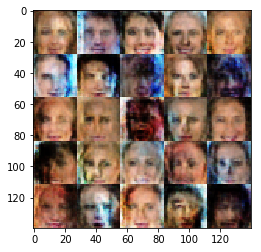

Epoch 1/1 
 Iteration 3100 
 Discriminator Loss = 0.9912 
 Generator Loss     = 1.1074 



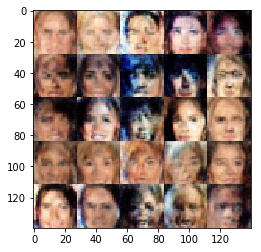

Epoch 1/1 
 Iteration 3200 
 Discriminator Loss = 1.2002 
 Generator Loss     = 0.6022 



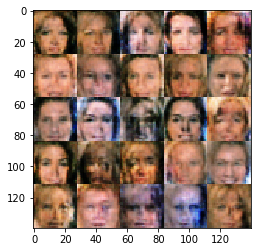

Epoch 1/1 
 Iteration 3300 
 Discriminator Loss = 1.5095 
 Generator Loss     = 0.9107 



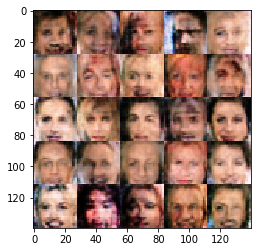

Epoch 1/1 
 Iteration 3400 
 Discriminator Loss = 1.3117 
 Generator Loss     = 1.0769 



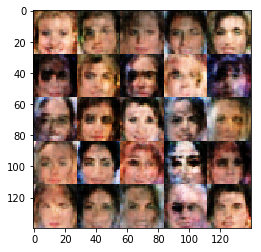

Epoch 1/1 
 Iteration 3500 
 Discriminator Loss = 1.3946 
 Generator Loss     = 0.7920 



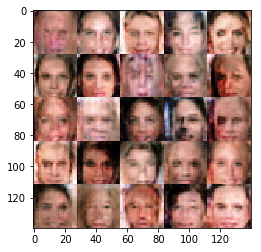

Epoch 1/1 
 Iteration 3600 
 Discriminator Loss = 1.3029 
 Generator Loss     = 1.4612 



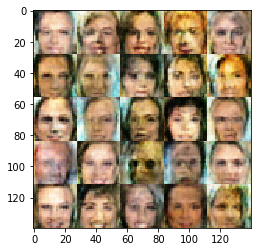

Epoch 1/1 
 Iteration 3700 
 Discriminator Loss = 1.2719 
 Generator Loss     = 0.7586 



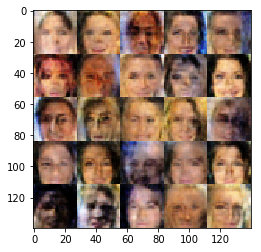

Epoch 1/1 
 Iteration 3800 
 Discriminator Loss = 1.3819 
 Generator Loss     = 0.8872 



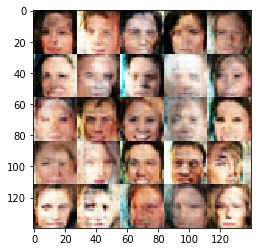

Epoch 1/1 
 Iteration 3900 
 Discriminator Loss = 1.4139 
 Generator Loss     = 1.0311 



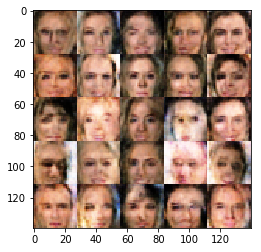

Epoch 1/1 
 Iteration 4000 
 Discriminator Loss = 1.2605 
 Generator Loss     = 1.2069 



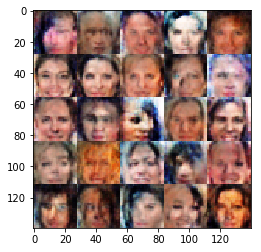

Epoch 1/1 
 Iteration 4100 
 Discriminator Loss = 1.2549 
 Generator Loss     = 1.0923 



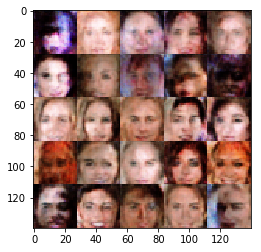

Epoch 1/1 
 Iteration 4200 
 Discriminator Loss = 1.3421 
 Generator Loss     = 0.9560 



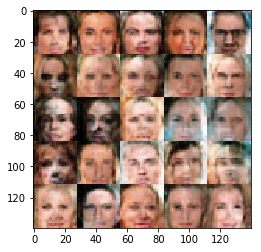

Epoch 1/1 
 Iteration 4300 
 Discriminator Loss = 1.8060 
 Generator Loss     = 0.3139 



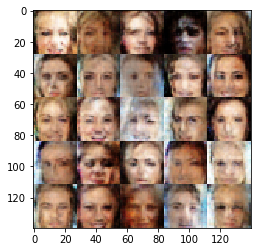

Epoch 1/1 
 Iteration 4400 
 Discriminator Loss = 1.2691 
 Generator Loss     = 1.2762 



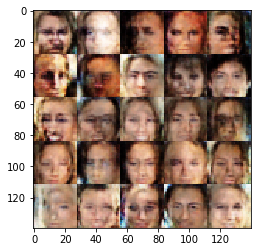

Epoch 1/1 
 Iteration 4500 
 Discriminator Loss = 1.2485 
 Generator Loss     = 1.2112 



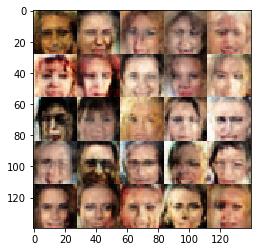

Epoch 1/1 
 Iteration 4600 
 Discriminator Loss = 1.1467 
 Generator Loss     = 1.3637 



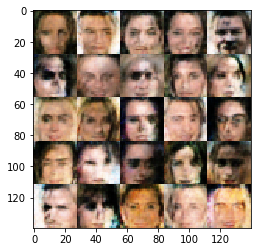

Epoch 1/1 
 Iteration 4700 
 Discriminator Loss = 1.1786 
 Generator Loss     = 1.1221 



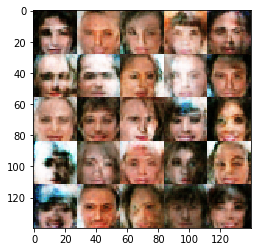

Epoch 1/1 
 Iteration 4800 
 Discriminator Loss = 1.2976 
 Generator Loss     = 1.6550 



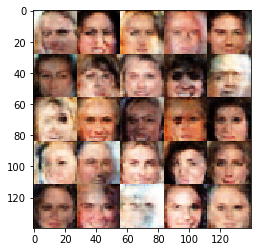

Epoch 1/1 
 Iteration 4900 
 Discriminator Loss = 1.7701 
 Generator Loss     = 0.4679 



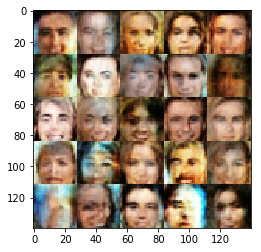

Epoch 1/1 
 Iteration 5000 
 Discriminator Loss = 1.2243 
 Generator Loss     = 0.8132 



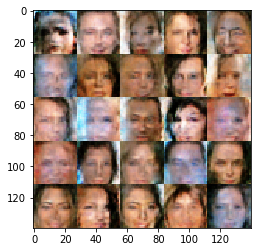

Epoch 1/1 
 Iteration 5100 
 Discriminator Loss = 1.7396 
 Generator Loss     = 1.2097 



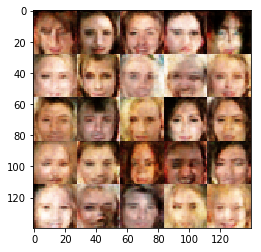

Epoch 1/1 
 Iteration 5200 
 Discriminator Loss = 1.1804 
 Generator Loss     = 0.9331 



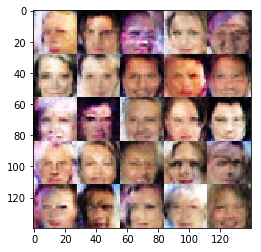

Epoch 1/1 
 Iteration 5300 
 Discriminator Loss = 1.3980 
 Generator Loss     = 1.2589 



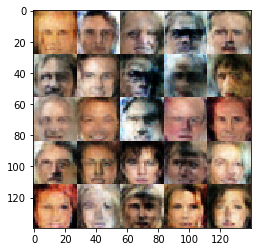

Epoch 1/1 
 Iteration 5400 
 Discriminator Loss = 1.2120 
 Generator Loss     = 1.0463 



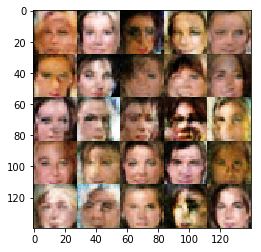

Epoch 1/1 
 Iteration 5500 
 Discriminator Loss = 1.1007 
 Generator Loss     = 1.1996 



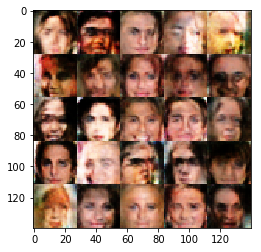

Epoch 1/1 
 Iteration 5600 
 Discriminator Loss = 1.4749 
 Generator Loss     = 0.4039 



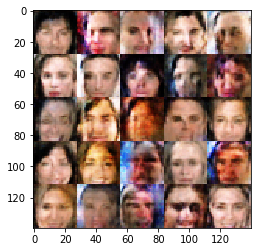

Epoch 1/1 
 Iteration 5700 
 Discriminator Loss = 1.2023 
 Generator Loss     = 0.8836 



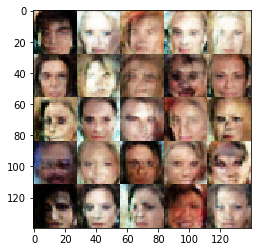

Epoch 1/1 
 Iteration 5800 
 Discriminator Loss = 1.2772 
 Generator Loss     = 0.5835 



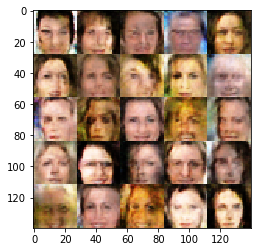

Epoch 1/1 
 Iteration 5900 
 Discriminator Loss = 1.4497 
 Generator Loss     = 1.0975 



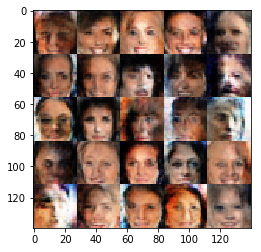

Epoch 1/1 
 Iteration 6000 
 Discriminator Loss = 1.6025 
 Generator Loss     = 0.7334 



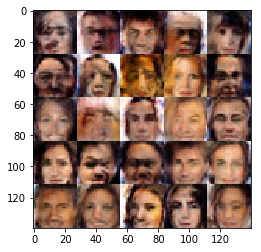

Epoch 1/1 
 Iteration 6100 
 Discriminator Loss = 1.0320 
 Generator Loss     = 1.3570 



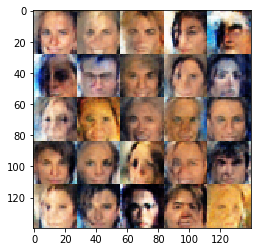

Epoch 1/1 
 Iteration 6200 
 Discriminator Loss = 0.9854 
 Generator Loss     = 0.8108 



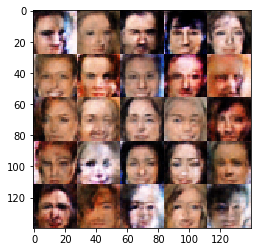

Epoch 1/1 
 Iteration 6300 
 Discriminator Loss = 1.3495 
 Generator Loss     = 1.0197 



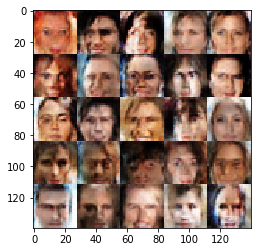

IndexError: list index out of range

In [19]:
batch_size    =  32
z_dim         = 100       # Matches feature sizes from DCGAN paper
learning_rate =   0.0002  # Recommended value from the DCGAN paper
beta1         =   0.5     # DCGAN paper indicated this would improve stability


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.